# Solving differential equations with dCGP

Lets first import dcgpy and pyaudi and set up things as to use dCGP on gduals defined over floats

In [1]:
from dcgpy import expression_gdual_vdouble as expression
from dcgpy import kernel_set_gdual_vdouble as kernel_set
from pyaudi import gdual_vdouble as gdual
from matplotlib import pyplot as plt
import numpy as np
from numpy import sin, cos
from random import randint
np.seterr(all='ignore') # avoids numpy complaining about early on malformed expressions being evalkuated
%matplotlib inline

## 1 - We define the set of kernel functions we will be using

In [2]:
kernels = kernel_set(["sum", "diff", "div", "mul", "log", "sin", "cos", "exp"])() # note the call operator (returns the list of kernels)

## 2 - We instantiate a dCGP and we inspect a randomly created program

In [3]:
dCGP = expression(inputs=2, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = 13)

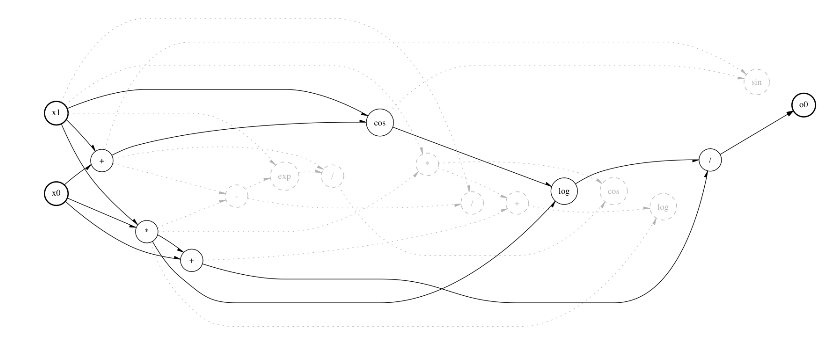

ValueError: Input size is incompatible

In [15]:
plt.rcParams["figure.figsize"] = [10,6]
dCGP.visualize() #requires pygraphwiz module installed
print("Represented expression: ", dCGP(["x"])[0])
print("Simplified expression: ", dCGP.simplify(["x"])) #requires sympy module installed

# 3 - We define the ES that will evolve solutions

In [66]:
# We run an evolutionary strategy ES(1 + offspring)
def run_experiment(max_gen, offsprings, quadratic_error, initial_conditions_error, screen_output=False):
    dCGP = expression(inputs=2, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    chromosome = [1] * offsprings
    fitness = [1] *offsprings
    best_chromosome = dCGP.get()
    best_fitness = quadratic_error(dCGP, grid) + initial_conditions_error(dCGP)
    for g in range(max_gen):
        for i in range(offsprings):
            dCGP.set(best_chromosome)
            dCGP.mutate_active(i) #  we mutate a number of increasingly higher active genes
            qe = quadratic_error(dCGP, grid)
            ie = initial_conditions_error(dCGP)
            fitness[i] = ie + qe
            chromosome[i] = dCGP.get()
        for i in range(offsprings):
            if fitness[i] <= best_fitness:
                if (fitness[i] != best_fitness) and screen_output:
                    print("New best found: gen: ", g, " value: ", fitness[i])
                best_chromosome = chromosome[i]
                best_fitness = fitness[i]
                dCGP.set(best_chromosome)
        if best_fitness < 1e-7:
            break
    return g, best_chromosome

## 4 - We consider the following Ordinary Differential Equation (ODE1):

$\frac{dy}{dx} = \frac{2x - y}{x}$, with $y(0.1) = 20.1$ and $x \in [0.1,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

The solution to the ODE is $y = x + \frac 2x$

In [6]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE1(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    x = np.array(grid.constant_cf)
    ode1 = (2. * x - y) / x
    retval += (ode1 - dydx) * (ode1 - dydx)
    return sum(retval)

In [7]:
# We define a penalty term associated to the initial conditions violation
def ic_ODE1(dCGP):
    x0 = 1
    y0 = 3
    out = dCGP([gdual([x0])])[0]
    return (out.constant_cf[0] - y0) * (out.constant_cf[0] - y0)

In [8]:
# We construct the grid of points. Since the ODE only contains first order derivatives we use truncation order 1.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0.1,1,10)
grid = gdual(values, "x", 1)

In [9]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
offsprings = 10
stop = 400
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_ODE1, initial_conditions_error=ic_ODE1)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
0 		 336 	 ['((((x/x)/x)+x)+((x/x)/x))']  a.k.a  [x + 2/x]
6 		 74 	 ['(((exp((x-x))+exp((x-x)))/x)+x)']  a.k.a  [x + 2/x]
10 		 199 	 ['((x*(x/x))+(((x/x)+(x/x))/x))']  a.k.a  [x + 2/x]
13 		 394 	 ['(x+((x+x)/(x*x)))']  a.k.a  [x + 2/x]
14 		 55 	 ['(x+(((sin(x)/sin(x))+(sin(x)/sin(x)))/x))']  a.k.a  [x + 2/x]
23 		 344 	 ['((((x/x)/x)+((x/x)/x))+x)']  a.k.a  [x + 2/x]
28 		 323 	 ['(x+(((x+x)/x)/x))']  a.k.a  [x + 2/x]
29 		 174 	 ['(((x*x)+((x/x)+(x/x)))/x)']  a.k.a  [x + 2/x]
42 		 113 	 ['(x+(((x+x)/x)/x))']  a.k.a  [x + 2/x]
45 		 211 	 ['((x+(x-x))+(((x/x)+(x/x))/x))']  a.k.a  [x + 2/x]
46 		 91 	 ['(x+(((x/(x*(x/x)))+(x/x))/(x*(x/x))))']  a.k.a  [x + 2/x]
53 		 316 	 ['((((x+x)/x)/x)+x)']  a.k.a  [x + 2/x]
54 		 313 	 ['((x+((x/x)/x))+((x/x)/x))']  a.k.a  [x + 2/x]
55 		 121 	 ['(x+((cos((sin((x+x))-sin((x+x))))+cos((sin((x+x))-sin((x+x)))))/x))']  a.k.a  [x + 2/x]
59 		 253 	 ['((x/(x*x))+(((x/(x*x))+x)-((x-x)/(x-x))))']  a.k.a  [nan]
61 		 146 	

In [10]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 653 * 200)

ERT Expected run time - avg. number of function evaluations needed:  12776.2962963
Avg. number of function evaluations from Tsoulos paper:  130600


## 5 - We consider the following Ordinary Differential Equation (ODE2):

$\frac{dy}{dx} = \frac{1 - ycos(x)}{sin(x)}$, with $y(0.1) = \frac{2.1}{sin(0,1)}$ and $x \in [0.1,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = \frac{x+2}{sin(x)}$

In [11]:
# We construct the grid of points. Since the ODE only contains first order derivatives we use truncation order 1.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0.1,1,10)
grid = gdual(values, "x", 1)

In [12]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE2(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    x = np.array(grid.constant_cf)
    ode2 = (1. -  y * cos(x)) / sin(x)
    retval += (ode2 - dydx) * (ode2 - dydx)
    return sum(retval)

In [13]:
# We define a penalty term associated to the initial conditions violation
dummy = (2.1)/sin(0.1)
def ic_ODE2(dCGP):
    x0 = 0.1
    y0 = dummy
    out = dCGP([gdual([x0])])[0]
    return (out.constant_cf[0] - y0) * (out.constant_cf[0] - y0)

In [14]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 400
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_ODE2, initial_conditions_error=ic_ODE2)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
3 		 295 	 ['((((x+x)+(x/x))-(x-(x/x)))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
13 		 315 	 ['((((x/x)/sin(x))+exp(log((x/sin(x)))))+((x/x)/sin(x)))']  a.k.a  [x/sin(x) + 2/sin(x)]
44 		 341 	 ['(((x/x)+((x/x)+x))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
46 		 157 	 ['((x+((sin(x)/sin(x))+(sin(x)/sin(x))))/((sin(x)/sin(x))*sin(x)))']  a.k.a  [x/sin(x) + 2/sin(x)]
52 		 200 	 ['(((x/x)+(x+((x/x)/(x/x))))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
70 		 158 	 ['(((x/x)+((x/x)+x))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]


In [15]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 742 * 200)

ERT Expected run time - avg. number of function evaluations needed:  64953.3333333
Avg. number of function evaluations from Tsoulos paper:  148400


## 6 - We consider the following Ordinary Differential Equation (ODE5):

$\frac{d^2y}{dx^2} = 6\frac{dy}{dx} - 9y$, with $y(0) = 0$, $\frac{dy}{dx}(0)=2$ and $x \in [0,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = 2x \exp(3x)$

In [16]:
# We construct the grid of points. Since the ODE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0,1,10)
grid = gdual(values, "x", 2)

In [17]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE5(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    dydx2 = np.array(out.get_derivative({"dx" : 2}))
    x = np.array(grid.constant_cf)
    ode5 = 6. * dydx - 9 * y
    retval += (ode5 - dydx2) * (ode5 - dydx2)
    return sum(retval)

In [18]:
# We define a penalty term associated to the initial conditions violation
def ic_ODE5(dCGP):
    x0 = 1e-16 # avoids what seems a numerical problem with vectorized dual?
    y0 = 0.
    dy0 = 2.
    out = dCGP([gdual([x0], "x", 1)])[0]
    dCGP_y0 = out.constant_cf[0]
    dCGP_dy0 = out.get_derivative({"dx" : 1})[0]
    return (dCGP_y0 - y0) * (dCGP_y0 - y0) + (dCGP_dy0 - dy0) * (dCGP_dy0 - dy0)

In [21]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 400
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_ODE5, initial_conditions_error=ic_ODE5)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
11 		 350 	 ['(((x*exp(x))+(x*exp(x)))*(exp(x)*exp(x)))']  a.k.a  [2*x*exp(3*x)]
12 		 254 	 ['((x+x)*(exp(x)*(exp(x)*exp(x))))']  a.k.a  [2*x*exp(3*x)]
13 		 205 	 ['(exp(((x+x)+x))*(x+x))']  a.k.a  [2*x*exp(3*x)]
18 		 261 	 ['((exp(x)*(x+x))*(exp(x)*exp(x)))']  a.k.a  [2*x*exp(3*x)]
27 		 340 	 ['(exp(x)*(((x+x)*exp(x))*exp(x)))']  a.k.a  [2*x*exp(3*x)]
29 		 123 	 ['(exp(x)*(((x+x)*exp(x))*exp(x)))']  a.k.a  [2*x*exp(3*x)]
37 		 205 	 ['(exp(((x+x)+x))*(((x+x)+x)-x))']  a.k.a  [2*x*exp(3*x)]
44 		 233 	 ['((x+x)*exp((x+(x+x))))']  a.k.a  [2*x*exp(3*x)]
45 		 269 	 ['(exp(((x+x)+x))*(x+x))']  a.k.a  [2*x*exp(3*x)]
51 		 225 	 ['((exp(x)*(x*(exp(x)+exp(x))))*exp(x))']  a.k.a  [2*x*exp(3*x)]
56 		 361 	 ['((exp(x)*x)*((exp(x)+exp(x))*exp(x)))']  a.k.a  [2*x*exp(3*x)]
57 		 112 	 ['((x*((exp(x)*exp(x))+(exp(x)*exp(x))))*exp(x))']  a.k.a  [2*x*exp(3*x)]
66 		 287 	 ['(exp(x)*(exp((x+x))*(x+x)))']  a.k.a  [2*x*exp(3*x)]
97 		 232 	 ['((x+x)*exp(((x+x)+x)))']

In [22]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 441 * 200)

ERT Expected run time - avg. number of function evaluations needed:  26979.2857143
Avg. number of function evaluations from Tsoulos paper:  88200


## 7 - We consider the following non linear Ordinary Differential Equation (NLODE3):

$\frac{d^2y}{dx^2}\frac{dy}{dx} = -\frac4{x^3}$, with $y(1) = 0$, and $x \in [1,2]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = log(x^2)$

In [23]:
# We construct the grid of points. Since the ODE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(1,2,10)
grid = gdual(values, "x", 2)

In [24]:
# We define the quadratic error of the dCGP in the grid points
def qe_NLODE3(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    dydx2 = np.array(out.get_derivative({"dx" : 2}))
    x = np.array(grid.constant_cf)
    nlode3 = dydx2*dydx
    retval += (nlode3 + 4/x/x/x) * (nlode3 + 4/x/x/x)
    return sum(retval)

In [25]:
# We define a penalty term associated to the initial conditions violation
def ic_NLODE3(dCGP):
    x0 = 1.
    y0 = 0.
    out = dCGP([gdual([x0])])[0]
    dCGP_y0 = out.constant_cf[0]
    dCGP_dy0 = out.get_derivative({"dx" : 1})[0]
    return (dCGP_y0 - y0) * (dCGP_y0 - y0)

In [26]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 400
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_NLODE3, initial_conditions_error=ic_NLODE3)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
0 		 26 	 ['(log((x*x))+(sin(((x*x)+x))-sin(((x*x)+x))))']  a.k.a  [log(x**2)]
1 		 25 	 ['((log(((x/x)*x))*(x/x))+(log(((x/x)*x))*(x/x)))']  a.k.a  [2*log(x)]
2 		 38 	 ['log((x*x))']  a.k.a  [log(x**2)]
3 		 180 	 ['log((x*x))']  a.k.a  [log(x**2)]
4 		 13 	 ['((x-x)-log((x*x)))']  a.k.a  [-log(x**2)]
5 		 9 	 ['log((x*x))']  a.k.a  [log(x**2)]
6 		 83 	 ['log((x*x))']  a.k.a  [log(x**2)]
7 		 23 	 ['log((x*x))']  a.k.a  [log(x**2)]
9 		 10 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
10 		 1 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
11 		 24 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
12 		 157 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
13 		 66 	 ['log(((x*x)+(cos(cos(x))-cos(cos(x)))))']  a.k.a  [log(x**2)]
14 		 26 	 ['log(((x/(x*x))/((x*x)/x)))']  a.k.a  [log(x**(-2))]
16 		 50 	 ['((log(x)+((x+x)-(x+x)))+log(x))']  a.k.a  [2*log(x)]
17 		 13 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
18 		 5 	 ['log((x*x))']  a.k.a  [log(x**2)]
19 		 23 	 ['(log(x)+log(x))']  

In [27]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 191 * 200)

ERT Expected run time - avg. number of function evaluations needed:  835.280898876
Avg. number of function evaluations from Tsoulos paper:  38200


## 8 - We consider the following non linear Patial Differential Equation (PDE1):

$\nabla^2 \psi(x,y) = \exp(-x)(x-2 + y^3 + 6y)$ with $x\in[0,1]$, $y\in[0,1]$ and boundary conditions: $\psi(0,y) = y^3$, $\psi(1,y) = (1+y^3)\exp(-1)$

we demand its punctual validity over a squared grid of $N$ equally spaced points.

NOTE: The solution to the PDE is $\psi(x,y) = (x+y^3)\exp(-x)$

In [154]:
# We construct the grid of points. Since the PDE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual
N=10
values = np.linspace(0,5,N)
xval = np.append(values,[values]*(N-1))
yval = values.repeat(N)
grid = [gdual(xval, "x", 2), gdual(yval, "y", 2)]

In [155]:
# We define the quadratic error of the dCGP in the grid points
def qe_PDE1(dCGP, grid):
    retval = 0
    out = dCGP([grid[0], grid[1]])[0]
    dpsidx2 = np.array(out.get_derivative({"dx" : 2}))
    dpsidy2 = np.array(out.get_derivative({"dy" : 2}))
    x = np.array(grid[0].constant_cf)
    y = np.array(grid[1].constant_cf)  
    pde1 = np.exp(-x) * (x-2+y*y*y+6*y)
    retval += (pde1 - dpsidx2 - dpsidy2) * (pde1 - dpsidx2 - dpsidy2)
    return sum(retval)

In [156]:
# We define a penalty term associated to the initial conditions violation
em1 = np.exp(-1)
def ic_PDE1(dCGP):
    x0 = gdual([0]*N)
    y0 = gdual(values)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = psi.constant_cf
    err1 = (dCGP_psi - values*values*values) * (dCGP_psi - values*values*values)
    x0 = gdual([1]*N)
    y0 = gdual(values)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = psi.constant_cf
    err2 = (dCGP_psi - (1+values*values*values)*em1) * (dCGP_psi - (1+values*values*values)*em1)
    return sum(err1) + sum(err2)

In [160]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 30
stop = 50000
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_PDE1, initial_conditions_error=ic_PDE1, screen_output=True)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x","y"]), " a.k.a ", dCGP.simplify(["x","y"]))
res = np.array(res)

restart: 	 gen: 	 expression:
New best found: gen:  0  value:  2488721020.7
New best found: gen:  0  value:  1434028.35672
New best found: gen:  1  value:  99879.8405679
New best found: gen:  2  value:  99550.2781855
New best found: gen:  4  value:  95081.3719244
New best found: gen:  20  value:  85207.5182922
New best found: gen:  27  value:  71793.2943904
New best found: gen:  32  value:  65955.4330838
New best found: gen:  42  value:  61634.5716499
New best found: gen:  48  value:  42051.231816
New best found: gen:  49  value:  41824.1769868
New best found: gen:  53  value:  37076.5343723
New best found: gen:  130  value:  12256.9410845
New best found: gen:  149  value:  12256.9410845
New best found: gen:  280  value:  12020.5218711
New best found: gen:  286  value:  10804.4127297
New best found: gen:  1001  value:  10532.6724673
New best found: gen:  2136  value:  9467.38215214
New best found: gen:  2138  value:  9226.13946646
New best found: gen:  2269  value:  7867.50870292
New b

KeyboardInterrupt: 

In [110]:
dCGP.simplify(["x","y"])

y**2*sin(y) - y*sin(y)

In [13]:
print(dCGP.get())

[0, 1, 0, 3, 1, 0, 0, 0, 3, 1, 3, 2, 7, 5, 1, 2, 6, 2, 6, 2, 1, 3, 1, 3, 2, 1, 5, 0, 4, 9, 4, 8, 3, 6, 9, 7, 4, 11, 3, 2, 4, 12, 5, 2, 8, 15]


In [159]:
plt.rcParams["figure.figsize"] = [12,10]
x = [3, 1, 1, 3, 1, 2, 0, 0, 3, 1, 1, 0, 1, 5, 1, 7, 6, 2, 3, 7, 4, 3, 1, 3, 2, 1, 5, 0, 4, 9, 4, 8, 3, 6, 9, 7, 4, 11, 3, 2, 4, 12, 5, 2, 8, 8]
dCGP.set([3, 1, 1, 3, 1, 2, 0, 0, 3, 1, 1, 0, 1, 5, 1, 7, 6, 2, 3, 7, 4, 3, 1, 3, 2, 1, 5, 0, 4, 9, 4, 8, 3, 6, 9, 7, 4, 11, 3, 2, 4, 12, 5, 2, 8, 8])
print(dCGP.simplify(["x","y"]))
#dCGP.visualize() #requires pygraphwiz module installed
ic_PDE1(dCGP)
qe_PDE1(dCGP,grid)

x*exp(-x) + y**3*exp(-x)


3.9727428197009431e-27